<a href="https://colab.research.google.com/github/yoloso/hello-world/blob/master/Week7_class_Excercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision for Social Good 

This week we'll be exploring computer vision & neural networks by training a convolutional neural network (CNN) on ADDI (Automated computer-based Diagnosis system for Dermascopic Images) dataset. You are able to run this notebook on GPU to speed up training and predictions, since we are building a larger model than before (in the toolbar, click Edit->Notebook settings->Hardware accelerator). Run the below cell to get started (may take a few minutes to download data).

In [ ]:
import os, scipy.ndimage
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import keras.backend as K
from keras.objectives import binary_crossentropy
import requests
import zipfile
import io, random
import imageio
import numpy as np
import tensorflow as tf
from PIL import Image

tf.compat.v1.disable_eager_execution()

# Seed value for weight initialization
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Download and extract data.
print('Downloading data. This will take a couple minutes...')
r = requests.get("http://web.stanford.edu/class/cs21si/resources/unit4_resources.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
print('Finished downloading data!')

base_path = 'unit4_resources/addi/'
train_path = base_path + 'train'
val_path = base_path + 'val'
test_path = base_path + 'test'

Finished downloading data!


## Part 1: Explore and Load the Data

Check out some of the images from the dataset by running the code below! Feel free to change the indices ("index") to look through other images

Showing normal image with index 0


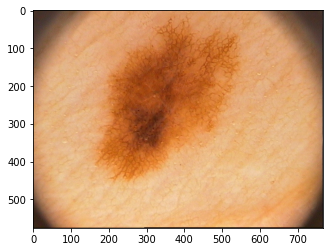

Showing abnormal image with index 0


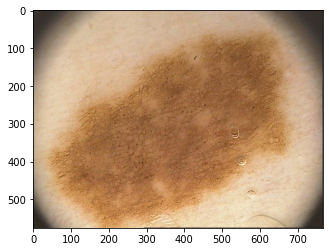

In [ ]:
# Let's plot some images from the data to better understand it.
def show_example(label, index=0):
    img_name = os.listdir('%s/%s' % (train_path, label))[index]
    path = '%s/%s/%s' % (train_path, label, img_name)
    img = plt.imread(path)
    print('Showing %s image with index %d' % (label, index))
    plt.figure()
    plt.imshow(img)
    plt.show()

# Try changing the indices to see more examples from the data!
show_example('normal', index=0)
show_example('abnormal', index=0)

Below, we have code that loads the data as an ImageDataGenerator, which will make it convenient for the Keras framework to deal with. Notice that the train generator has more input parameters--these are called data augmentations and allow us to generalize better when we have little training data. Read more about data augmentation [here](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced).

Run the code below to load the data.

In [ ]:
def load_data(batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_path, 
                                                        target_size=(150, 150),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

    val_generator = test_datagen.flow_from_directory(val_path,
                                                     target_size=(150, 150),
                                                     batch_size=batch_size,
                                                     class_mode='binary')
    
    test_generator = test_datagen.flow_from_directory(test_path,
                                                      target_size=(150, 150),
                                                      batch_size=25,
                                                      class_mode='binary',
                                                      shuffle=False)
    
    return train_generator, val_generator, test_generator

train_generator, val_generator, test_generator = load_data(16)

Found 125 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


## Part 2: Create and Train a CNN

We will now write the code to create, load, and train a CNN. We will then evaluate the model on the validation and test sets to see how it performs on unseen data.

Write the code for your simple CNN below. Check out the [Keras documentation on CNNs](https://keras.io/layers/convolutional/) for reference!

In [ ]:
def get_cnn():
    ### YOUR CODE HERE ###
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    ### END CODE ###
    return model

model = get_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        1

You may notice that our model is quite huge for just a few examples. Yes, we are definitely overfitting our data. However, without understanding your data, and instead focusing just on metrics, we will make various mistakes in our modeling (including overfitting). We will talk about these errors shortly!

Run the code below to train your simple model on the training data, evaluating on the validation data at every epoch.

In [ ]:
def train_model(train_generator, validation_generator, epochs=5):

    model = get_cnn()

    model.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=epochs,
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator))
    return model
    
model = train_model(train_generator, val_generator, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
8/8 [==============================] - ETA: 0s - batch: 3.5000 - size: 15.6250 - loss: 3.5027 - accuracy: 0.6080

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8/8 [==============================] - 11s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 3.5027 - accuracy: 0.6080 - val_loss: 0.8414 - val_accuracy: 0.4000
Epoch 2/10
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 2.2502 - accuracy: 0.6800 - val_loss: 0.9794 - val_accuracy: 0.4000
Epoch 3/10
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 1.1761 - accuracy: 0.6960 - val_loss: 1.3223 - val_accuracy: 0.4000
Epoch 4/10
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 1.3036 - accuracy: 0.6240 - val_loss: 1.6253 - val_accuracy: 0.4000
Epoch 5/10
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 0.8627 - accuracy: 0.6960 - val_loss: 1.2955 - val_accuracy: 0.4000
Epoch 6/10
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 15.6250 - loss: 0.7811 - accuracy: 0.6560 - val_loss: 1.2671 - val_accuracy: 0.4

Because there is a lot of randomness to the training process, we will load a model which we have already trained and optimize for the rest of the exercises:

In [ ]:
model = load_model('unit4_resources/trained_model.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 32)       

Evaluate your model on the test set below! The first number is the loss, and the second is the accuracy. You should be able to get around 70% accuracy on the test set with the model.

In [ ]:
#use the test data generator to evaluate model performance
metric_values = model.evaluate_generator(test_generator, len(test_generator))
# Get the names of metrics and produce a dictionary mapping from metric names
# to values.
print(dict(zip(model.metrics_names, metric_values)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


{'loss': 0.9514626860618591, 'accuracy': 0.72}


## Part 3: Disparate Performance

We trained our model with the intent of increasing accuracy of the model on the validation and test sets. However, having a metric-centric approach leaves some blind spots. We will discuss some issues that our model has below.

First, let's check out the test set. Notice that there are four images which are more "reddish" than the rest.

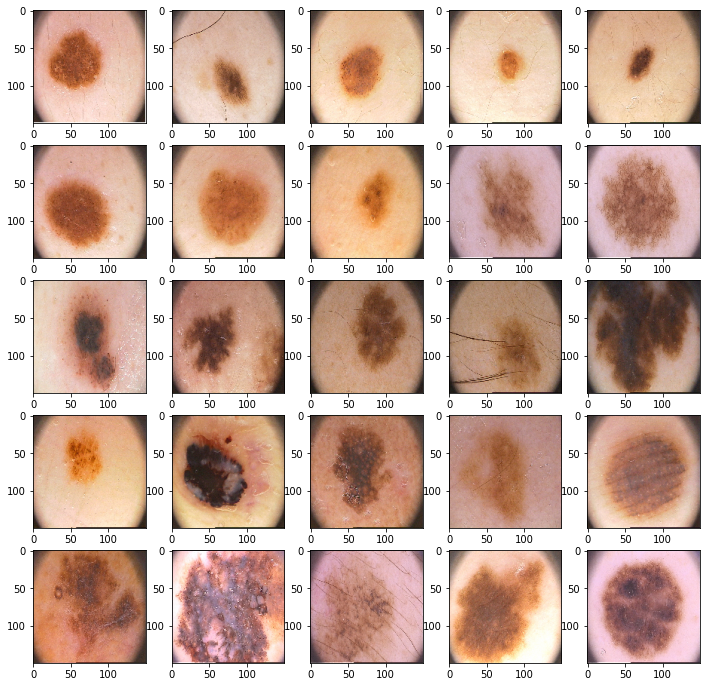

In [ ]:
_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for imgs, _ in test_generator:
  for img, ax in zip(imgs, axs):
      ax.imshow(img)
  break
plt.show()

Now, let's check out the misclassifications. Notice that, out of the 7 misclassifications, 2 are of reddish skin. This is a huge issue, because it means that half of the reddish skin examples of the test set are misclassified. A 50% error rate on that group is huge!

(Note: the label for "abnormal" is 0 and the label for "normal" is 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1301: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted normal (ground truth is abnormal)


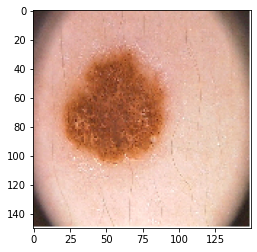

Predicted normal (ground truth is abnormal)


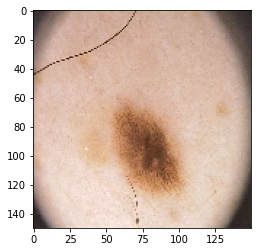

Predicted normal (ground truth is abnormal)


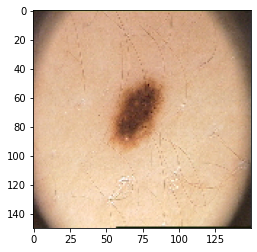

Predicted normal (ground truth is abnormal)


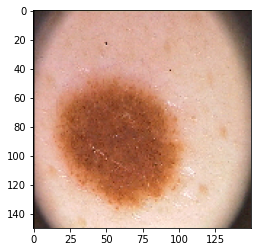

Predicted normal (ground truth is abnormal)


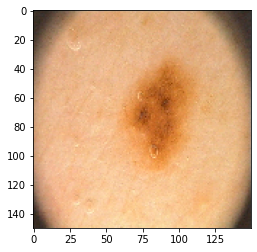

Predicted normal (ground truth is abnormal)


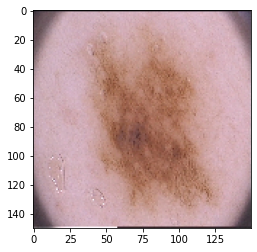

Predicted normal (ground truth is abnormal)


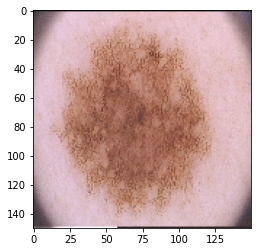

In [ ]:
pred = model.predict_generator(test_generator, len(test_generator))
pred = (pred > 0.5).astype(float)

for imgs, labels in test_generator:
  for i in range(len(labels)):
    if labels[i] != pred[i]:
      plt.figure()
      plt.imshow(imgs[i])
      print("Predicted %s (ground truth is %s)" % ('normal' if pred[i] >= 0.5 else 'abnormal', 'normal' if labels[i] >= 0.5 else 'abnormal'))
      plt.show()

  break

## Part 4: Adversarial Attacks

Now, let's turn our attention to another shortcoming: adversarial attacks. This is an instance where targeted noise is added to the an image to change its predicts from one class to another. In the below, case, we will add noise to turn an abnormal example into a "normal" example as according to the model. To learn more about adversarial example, check out [this article](https://openai.com/blog/adversarial-example-research/#:~:text=Machine%20Learning-,with%20Adversarial,like%20optical%20illusions%20for%20machines.)

Load the abnormal example below. Notice that the model's prediction is very below 0.5, and therefore it is believes that this example is abnormal (remember: the label for abnormal is 0).

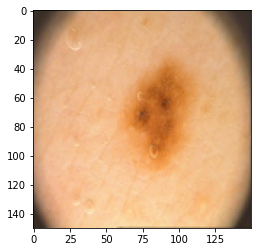

Prediction using this image: normal (raw prediction: 0.54)


In [ ]:
abnormal_path = 'unit4_resources/addi/test/abnormal/'
img_path = abnormal_path + os.listdir(abnormal_path)[8]

img = imageio.imread(img_path)
img = np.array(Image.fromarray(img).resize((150, 150)))[np.newaxis, :, :, :].astype(float)/255.0

plt.imshow(np.squeeze(img))
plt.show()

pred = model.predict(img)[0, 0]
print("Prediction using this image: %s (raw prediction: %0.2f)" % ('normal' if pred >= 0.5 else 'abnormal', pred))

Now, we will add noise to the image to change the model's prediction.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


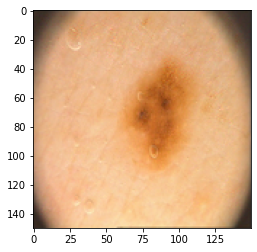

Prediction using this image: normal (raw prediction: 0.94)


In [ ]:
pertubation_amount = 0.2
def add_targetted_noise(fooling_img):
  for _ in range(15):
    # Get the loss value and the gradient of the image with respect to 
    # output probability
    y_true = K.placeholder((1, 1))
    loss = K.mean(binary_crossentropy(y_true, model.output))
    get_grads = K.function([model.input, y_true], K.gradients(loss, model.input))

    # Perturb the image so as to increase the probability
    grad = -get_grads([fooling_img, [[0]]])[0]
    fooling_img = fooling_img - pertubation_amount*grad
    
    # Break once we have a very high probability
    pred = model.predict(fooling_img)[0, 0]
    if pred >= 0.95:
        break
  
  return fooling_img

fooling_img = add_targetted_noise(img.copy())

plt.imshow(np.squeeze(fooling_img))
plt.show()
pred = model.predict(fooling_img)[0, 0]
print("Prediction using this image: %s (raw prediction: %0.2f)" % ('normal' if pred >= 0.5 else 'abnormal', pred))

This is really scary! What's especially scary is that the noisy image doesn't look too different from the original image at all. Run the code below to see the difference between the two images, mutliplied by 100 (without the scaling, there is literally no visible difference between the images).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


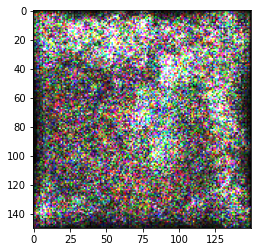

In [ ]:
plt.imshow(np.squeeze(np.abs((fooling_img - img) * 100)))
plt.show()